In [1]:
import pandas as pd
import numpy as np

def fetch_prices(tickers):
    files = [f'./data/processed/{asset}.csv' for asset in tickers]
    asset_data = [pd.read_csv(file) for file in files]
    benchmark_data = pd.read_csv('./data/djia.csv')
    return asset_data, benchmark_data

In [2]:
columns_to_observe = ['close','Return_1d_stock','Return_3d_stock','Return_5d_stock','Return_10d_stock','Return_50d_stock','Return_100d_stock','Return_1d_Correlation','Return_3d_Correlation','Return_5d_Correlation','Return_10d_Correlation','Return_50d_Correlation','Return_100d_Correlation','ADX','Aroon_Up','Aroon_Down','CCI','EMA','KAMA','ROC','RSI','CMF','ADI','FI','Bollinger_high','Bollinger_low','Donchian_low','Donchian_high']

def fetch_observations(assets:list[pd.DataFrame],benchmark:pd.DataFrame,period,start_date,end_date):
    assets = [asset[(asset['date'] >= start_date) & (asset['date'] <= end_date)] for asset in assets]
    benchmark = benchmark[(benchmark['date'] >= start_date) & (benchmark['date'] <= end_date)]
    dates = np.array(benchmark['date'].values)
    
    prices = [asset['close'].iloc[::period].values for asset in assets]
    
    prices_array = np.array(prices,dtype=np.float32).T
    benchmark_array = np.array(benchmark['close'].iloc[::period].values,dtype=np.float32)
    
    observations = []
    for asset in assets:
        asset_obs = []
        for column in columns_to_observe:
            asset_obs.append(np.array(asset[column].shift(1).dropna().iloc[::period].values,dtype=np.float32)) # shift by 1 to avoid look-ahead bias
            
        observations.append(asset_obs)
        
    observations_array = np.array(observations).transpose(2, 0, 1)
    return prices_array, benchmark_array, observations_array, dates

In [3]:
from gymnasium import spaces,Env
import numpy as np

ACTION_BOUND = 6

class PortfolioEnv(Env):
    def __init__(self, observation_timeline:np.ndarray, data_timeline:np.ndarray, benchmark_timeline:np.ndarray, investment_period=3,reward_period=10,risk_aversion=0.5):
        self.num_of_assets = data_timeline.shape[1]
        self.investment_freq = investment_period
        self.reward_freq = reward_period
        self.risk_aversion = risk_aversion
        
        self.observation_timeline = observation_timeline
        self.data_timeline = data_timeline
        self.benchmark_timeline = benchmark_timeline
        
        self.action_space = spaces.Box(low=0, high=ACTION_BOUND, shape=(self.num_of_assets+1,)) # +1 for cash
        
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.num_of_assets*len(columns_to_observe),))
        
        self.portfolio_returns:list[float] = []
        self.benchmark_returns:list[float] = []
        
        self.current_step = 0
        self.current_worth = 1.0
        self.reset()
        
    def reset(self,seed=None):
        self.current_step = 0
        self.current_worth = 1.0
        info = {"porfolio_worth":self.current_worth}
        return self.get_observation(),info
    
    def step(self,action):
        self.calculate_asset_returns(action)
        self.calculate_benchmark_returns()
        
        done = False
        reward = 0.0
        if (self.current_step + 1) % self.reward_freq == 0:
            reward = self.calculate_reward()
            
        self.current_step += 1
        
        if self.current_step >= len(self.data_timeline)-1:
            done = True
            self.current_step = 0
        info = {"porfolio_worth":self.current_worth}
        return self.get_observation(), reward, done,False , info
    
    def get_observation(self):
        return self.observation_timeline[self.current_step].flatten()

    def calculate_asset_returns(self,action:np.ndarray):
        weights = self.calculate_weights(action)
        asset_wise_returns = np.zeros(self.num_of_assets+1)
        asset_wise_returns[:-1] = self.data_timeline[self.current_step+1]/self.data_timeline[self.current_step]
        asset_wise_returns[-1] = 1 
        portfolio_return = np.dot(weights,asset_wise_returns)
        self.current_worth *= portfolio_return
        self.portfolio_returns.append(np.log(portfolio_return))
        
    def calculate_weights(self,action:np.ndarray) -> np.ndarray:
        exp_action = np.exp(action - np.max(action))
        weights = exp_action/np.sum(exp_action)
        return np.round(weights,4)
    
    def calculate_benchmark_returns(self):
        self.benchmark_returns.append(np.log(self.benchmark_timeline[self.current_step+1]/self.benchmark_timeline[self.current_step]))
        
    def calculate_reward(self):
        diff = np.array(self.portfolio_returns) - np.array(self.benchmark_returns)
        mean_diff = np.mean(diff)
        var_diff = np.var(diff)
        corr = np.cov(self.portfolio_returns,self.benchmark_returns)[0,1]/(np.std(self.portfolio_returns)*np.std(self.benchmark_returns))
        self.portfolio_returns = []
        self.benchmark_returns = []
        
        return mean_diff - self.risk_aversion*(var_diff/(1-corr))
    
    def render(self):
        print(f"Step: {self.current_step}, Prices: {self.data_timeline[self.current_step]}")

In [4]:
from stable_baselines3.common.vec_env import DummyVecEnv

tickers = ['AAPL','JPM','F','PG', 'BA']

assets,benchmark = fetch_prices(tickers)
investment_period = 1 # each 3 investment days 
reward_period = 15 # each 10 investment periods
risk_aversion = 0.7
data_timeline,benchmark_timeline,observation_timeline,dates = fetch_observations(assets,benchmark,start_date='1992-01-01',end_date='2018-12-31',period=investment_period)

In [5]:

from stable_baselines3.common.env_checker import check_env
env = PortfolioEnv(observation_timeline=observation_timeline,data_timeline=data_timeline,benchmark_timeline=benchmark_timeline, reward_period=reward_period,investment_period=investment_period,risk_aversion=risk_aversion)

check_env(env)

env = DummyVecEnv([lambda: env])

d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\env_checker.py:453: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [6]:
from stable_baselines3 import  PPO, A2C, SAC, DDPG
from stable_baselines3.common.base_class import BaseAlgorithm
learning_rate=0.001
models_to_train: list[BaseAlgorithm] = [
    A2C('MlpPolicy', env, verbose=1,learning_rate=learning_rate),
    PPO('MlpPolicy', env, verbose=1,learning_rate=learning_rate),
    SAC('MlpPolicy', env, verbose=1,learning_rate=learning_rate),
    DDPG('MlpPolicy', env, verbose=1,learning_rate=learning_rate),
]

Using cpu device
Using cpu device
Using cpu device
Using cpu device


d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.70GB
  warnings.warn(
d:\.war\satan\.venv\Lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.15GB > 0.69GB
  warnings.warn(


In [ ]:
for model in models_to_train:
    model.learn(total_timesteps=20000,log_interval=1000)
    save_file_name = model.__class__.__name__ + f'_date_{dates[0]}_to_{dates[-1]}_risk_{risk_aversion}_inv_{investment_period}_rew_{reward_period}.zip'
    model.save(f'./models/{save_file_name}')

------------------------------------
| time/                 |          |
|    fps                | 405      |
|    iterations         | 1000     |
|    time_elapsed       | 12       |
|    total_timesteps    | 5000     |
| train/                |          |
|    entropy_loss       | -8.58    |
|    explained_variance | 0.0      |
|    learning_rate      | 0.001    |
|    n_updates          | 999      |
|    policy_loss        | -0.0214  |
|    std                | 1.01     |
|    value_loss         | 6.75e-06 |
------------------------------------
-----------------------------------------
| time/                 |               |
|    fps                | 468           |
|    iterations         | 2000          |
|    time_elapsed       | 21            |
|    total_timesteps    | 10000         |
| train/                |               |
|    entropy_loss       | -8.58         |
|    explained_variance | 1.1920929e-07 |
|    learning_rate      | 0.001         |
|    n_updates          |

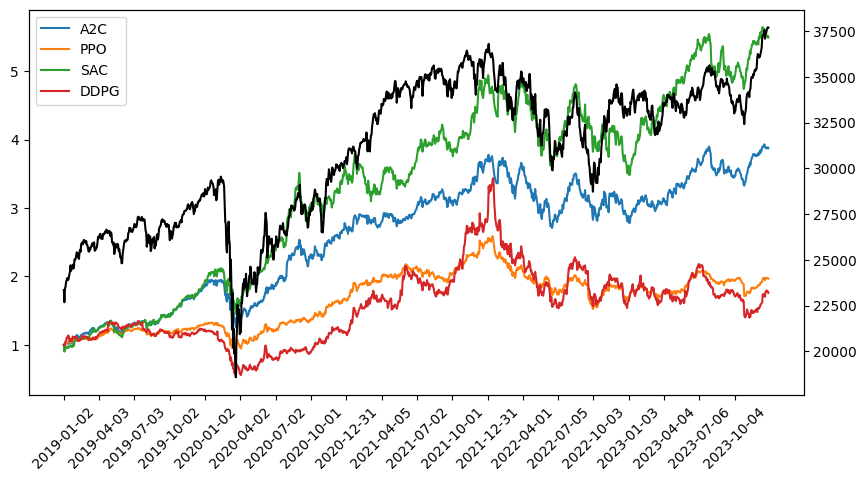

In [ ]:
import matplotlib.pyplot as plt

def evaluate_model(model:BaseAlgorithm,env:PortfolioEnv):
    done = False
    rewards = []
    portfolio_worths = []
    obs = env.reset()
    portfolio_worths.append(1.0)
    while not done:
        action, _states = model.predict(obs)
        obs, reward, done,info = env.step(action)
        portfolio_worths.append(info[0]['porfolio_worth'])
        rewards.append(reward)
    return np.array(rewards),np.array(portfolio_worths)


eval_prices,eval_benchmark,eval_observations,eval_dates = fetch_observations(assets,benchmark,start_date='2019-01-01',end_date='2023-12-31',period=investment_period)
eval_env = PortfolioEnv(observation_timeline=eval_observations,data_timeline=eval_prices,benchmark_timeline=eval_benchmark,investment_period=investment_period,reward_period=reward_period,risk_aversion=0.5)

check_env(eval_env)

eval_env = DummyVecEnv([lambda: eval_env])


plt.figure(figsize=(10,5))
model_titles = []
for model in models_to_train:
    rewards,portfolio_worths = evaluate_model(model,eval_env)
    model_name = model.__class__.__name__
    model_titles.append(model_name)
    plt.plot(eval_dates,portfolio_worths, linestyle='-',label=f'{model_name}')
    

plt.xticks(eval_dates[::63],rotation=45)
plt.legend()

plt.twinx()
plt.plot(eval_dates,eval_benchmark, linestyle='-',label='Benchmark',color='black')

    